In [20]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
import io
import os
import sys
import json
import django

import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import plot
offline.init_notebook_mode(connected=True)

BDIR = os.path.abspath(os.path.join(sys.argv[0], '../../../..'))

# run this file in project floder
sys.path.insert(0, '../../../xai-demo/')

# need this to run django models
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'xai_demo.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

django.setup()


In [22]:
from xai_backend.services import sample_ranking

songs = sample_ranking().content

df_songs = pd.DataFrame(json.loads(songs))

cols = ['acousticness', 'danceability', 'energy',
        'instrumentalness', 'key', 'liveness',
       'loudness', 'popularity', 'rank',
       'speechiness', 'tempo', 'valence']

df_songs_num = df_songs[cols]


In [23]:
import random
l = [i+1 for i in range(10)]
random.shuffle(l)
X_ = df_songs_num.copy()
X_['change'] = X_['rank'] - l
X_['rank_user'] =  X_['rank'] - X_['change']
X_

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,rank,speechiness,tempo,valence,change,rank_user
0,0.03830,0.591,0.764,0.000000,1,0.1030,-5.484,92,1.0,0.0483,169.928,0.478,-9.0,10.0
1,0.32100,0.677,0.696,0.000000,0,0.4200,-6.181,90,2.0,0.1190,90.030,0.464,-7.0,9.0
2,0.44000,0.761,0.525,0.000007,11,0.0921,-6.900,94,3.0,0.0944,80.870,0.531,-1.0,4.0
3,0.58400,0.442,0.612,0.000006,2,0.3700,-7.222,90,4.0,0.1120,180.917,0.178,1.0,3.0
4,0.17400,0.701,0.716,0.000000,7,0.3240,-3.671,89,5.0,0.0361,91.007,0.732,0.0,5.0
5,0.21300,0.662,0.413,0.000000,0,0.1340,-7.357,85,6.0,0.0299,93.005,0.467,-2.0,8.0
6,0.00776,0.762,0.766,0.000070,7,0.1280,-3.955,86,7.0,0.0343,130.001,0.442,1.0,6.0
7,0.46800,0.737,0.802,0.000000,0,0.0931,-4.771,88,8.0,0.0878,144.015,0.682,7.0,1.0
8,0.30400,0.664,0.609,0.000000,1,0.0926,-6.509,93,9.0,0.0707,130.041,0.194,7.0,2.0
9,0.16300,0.715,0.622,0.000000,4,0.0948,-5.102,86,10.0,0.0460,80.015,0.808,3.0,7.0


Double Machine Learning Model

In [24]:
from econml.dml import CausalForestDML, LinearDML, NonParamDML, KernelDML, DML, SparseLinearDML
import scipy
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

np.random.seed(100)
X = X_.copy()
_ = X.pop('rank')
T = X.pop('change')
y = X.pop('rank_user')

X=(X-X.mean())/X.std()
X=(X-X.min())/(X.max()-X.min())

est = LinearDML()
# est = CausalForestDML()

est.fit(y, T, X=X, W=None)

effect = est.effect(X)
pd.DataFrame(effect.reshape(1, -1)).append(X_.change)


,0,1,2,3,4,5,6,7,8,9
0,-0.477273,-0.398251,2.25,-2.333333,18.807573,-2.463914,-3.06774,-1.597567,-0.527778,0.375
change,-9.000000,-7.000000,-1.00,1.000000,0.000000,-2.000000,1.00000,7.000000,7.000000,3.000


In [25]:
dict(zip(X.columns, est.coef_))

{'acousticness': 9.407186480509775,
 'danceability': 6.684862845536922,
 'energy': -1.4807511458610683,
 'instrumentalness': -10.455691473888853,
 'key': 5.525049911264619,
 'liveness': 12.644538805488223,
 'loudness': 9.412881101854218,
 'popularity': 8.17766286902562,
 'speechiness': -17.48092580474838,
 'tempo': 1.0945562623381386,
 'valence': -0.9633958102122209}

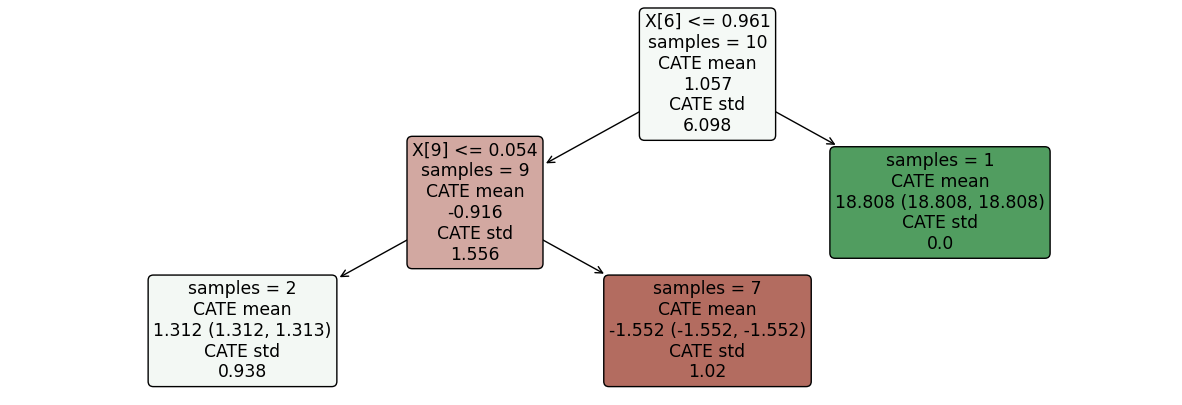

In [26]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(est, X)

plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()



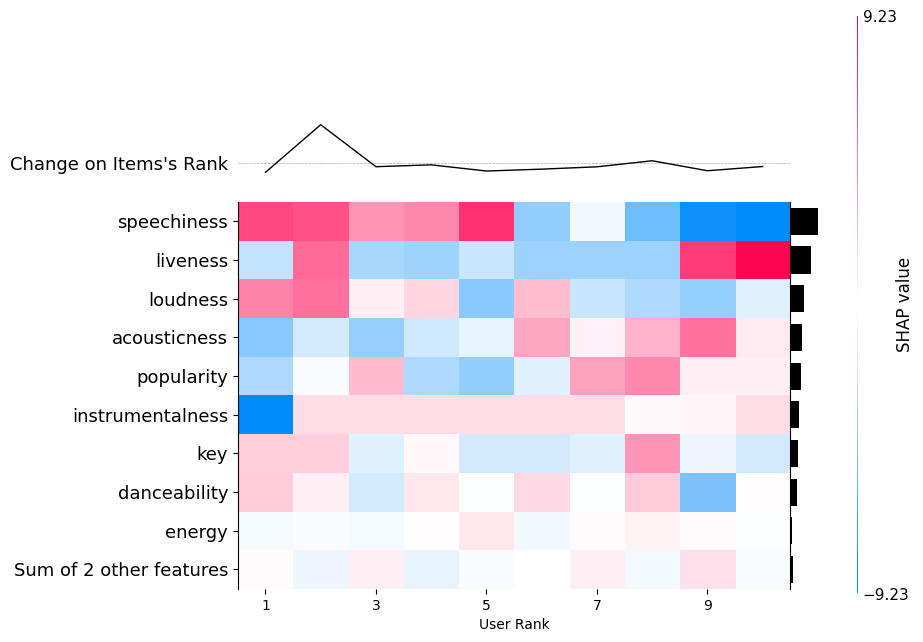

In [27]:
import shap
from shap.plots import heatmap
ind=0
shap_values = est.shap_values(X)
# shap.plots.force(shap_values["rank_user"]["change"][ind], matplotlib=True)
# shap.summary_plot(shap_values["rank_user"]["change"])
heatmap(shap_values["rank_user"]["change"], show=False)
ax = plt.gca()
ax.set_xlabel('User Rank')
# ax.set_ylabel('Change on items\' rank')
# ax.set_yticklabels(['Change on Items\'s Rank'])
yt = ax.get_yticklabels()
yt[0] = 'Change on Items\'s Rank'
xl = ax.get_xticklabels()
ax.set_yticklabels(yt)
ax.set_xticklabels([-2] + [i for i in range(1, 11, 2)])
plt.savefig('grafic.png')
# print(ax.get_yticklabels()[0])


In [28]:
ax.get_xticklabels()


[Text(-2.0, 0, '-2'),
 Text(0.0, 0, '1'),
 Text(2.0, 0, '3'),
 Text(4.0, 0, '5'),
 Text(6.0, 0, '7'),
 Text(8.0, 0, '9'),
 Text(10.0, 0, '')]

XGBRanker

[0.07775075 0.07944309 0.09515394 0.09741881 0.07532617 0.11583902
 0.03826183 0.10320532 0.05424967 0.1703492  0.09300213]


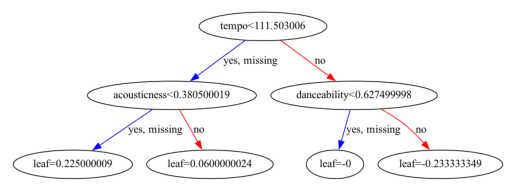

In [29]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='rank:pairwise')

X = X_.copy()
_ = X.pop('rank')
_ = X.pop('change')
y = X.pop('rank_user')

# X=(X-X.mean())/X.std()
# X=(X-X.min())/(X.max()-X.min())

model = model.fit(X, y)
print(model.feature_importances_)
xgb.plot_tree(model)
plt.show()

In [30]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=['down', 'up'],
    mode='regression'
)

exp = explainer.explain_instance(data_row=X.iloc[0], predict_fn=model.predict)
exp.show_in_notebook(show_table=True)


Decision Tree


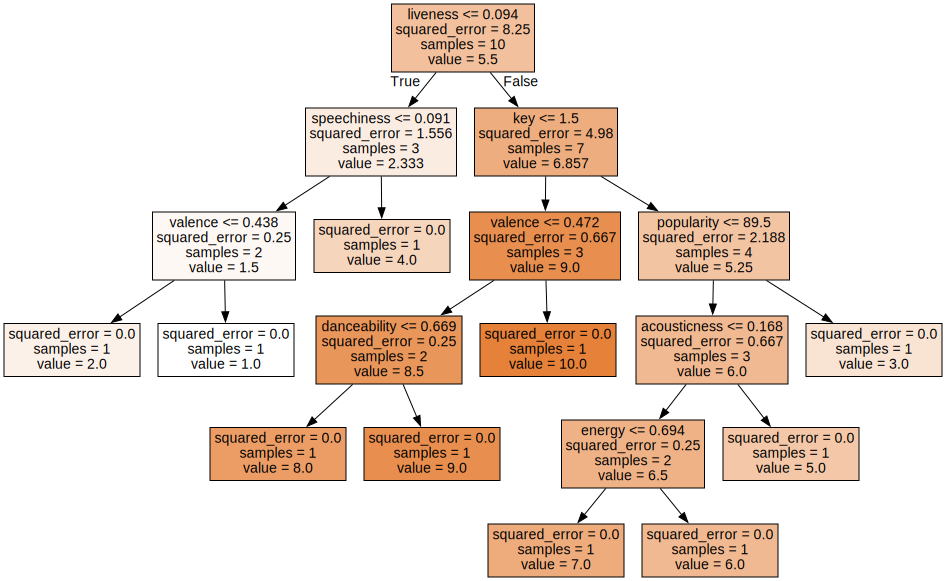

In [31]:
from sklearn import tree

X = X_.copy()
_ = X.pop('rank')
_ = X.pop('change')
y = X.pop('rank_user')

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns,  
                                class_names=y,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


Classifier

In [32]:
model = xgb.XGBClassifier()

X = X_.copy()
_ = X.pop('rank')
y = X.pop('change')
_ = X.pop('rank_user')

y = y.apply(lambda x: 0 if x < 0 else 1)

model.fit(X, y)

import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=['down', 'up'],
    mode='classification'
)

exp = explainer.explain_instance(data_row=X.iloc[9], predict_fn=model.predict_proba)
exp.show_in_notebook(show_table=True)



In [33]:
X_

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,rank,speechiness,tempo,valence,change,rank_user
0,0.03830,0.591,0.764,0.000000,1,0.1030,-5.484,92,1.0,0.0483,169.928,0.478,-9.0,10.0
1,0.32100,0.677,0.696,0.000000,0,0.4200,-6.181,90,2.0,0.1190,90.030,0.464,-7.0,9.0
2,0.44000,0.761,0.525,0.000007,11,0.0921,-6.900,94,3.0,0.0944,80.870,0.531,-1.0,4.0
3,0.58400,0.442,0.612,0.000006,2,0.3700,-7.222,90,4.0,0.1120,180.917,0.178,1.0,3.0
4,0.17400,0.701,0.716,0.000000,7,0.3240,-3.671,89,5.0,0.0361,91.007,0.732,0.0,5.0
5,0.21300,0.662,0.413,0.000000,0,0.1340,-7.357,85,6.0,0.0299,93.005,0.467,-2.0,8.0
6,0.00776,0.762,0.766,0.000070,7,0.1280,-3.955,86,7.0,0.0343,130.001,0.442,1.0,6.0
7,0.46800,0.737,0.802,0.000000,0,0.0931,-4.771,88,8.0,0.0878,144.015,0.682,7.0,1.0
8,0.30400,0.664,0.609,0.000000,1,0.0926,-6.509,93,9.0,0.0707,130.041,0.194,7.0,2.0
9,0.16300,0.715,0.622,0.000000,4,0.0948,-5.102,86,10.0,0.0460,80.015,0.808,3.0,7.0


In [34]:
exp.as_list()

[('tempo <= 90.27', -0.19685304248211516),
 ('1.50 < key <= 6.25', 0.10719350307126542),
 ('popularity <= 86.50', 0.09126075509170399),
 ('acousticness <= 0.17', -0.05848879302241936),
 ('-5.83 < loudness <= -4.85', 0.011402843897952758),
 ('valence > 0.64', 0.009478635678750126),
 ('instrumentalness <= 0.00', -0.007989992094482035),
 ('0.69 < danceability <= 0.73', -0.00287608516387674),
 ('0.09 < liveness <= 0.12', 0.0022796639138128677),
 ('0.61 < energy <= 0.66', 0.0007936744731684781)]

In [36]:
exp.as_map()

{1: [(9, -0.19685304248211516),
  (4, 0.10719350307126542),
  (7, 0.09126075509170399),
  (0, -0.05848879302241936),
  (6, 0.011402843897952758),
  (10, 0.009478635678750126),
  (3, -0.007989992094482035),
  (1, -0.00287608516387674),
  (5, 0.0022796639138128677),
  (2, 0.0007936744731684781)]}